<a href="https://colab.research.google.com/github/jeffmcm1977/CMBAnalysis_SummerSchool/blob/master/CMB_School_Part_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Analysis
### Jeff McMahon and Renée Hložek 

We will analyze these maps in several ways. First, in this part, we will use a Monte Carlo technique to recover the power spectrum, with exercises along the way. In part five we will, use a matched filter to isolate the SZ signal and point sources, and work through stacking a map on a cluster catalogue from a simulated external survey (e.g., optical or x-ray).

## Power spectrum
 
In this section we compute the power spectrum of a CMB map.  We will work in the flat sky approximation which is described above in the section where we generated the simulated CMB map.  

In [1]:
!python -c "import cmb_modules" || ( \
    wget cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

In [2]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

## Recalculating the results from the previous stages

/home/matias/Documentos/PhD/CMBAnalysis_SummerSchool/cmb_modules.py:15: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


Number of sources required:  5000
map mean: -19.99416106102335 map rms: 103.3871744358756


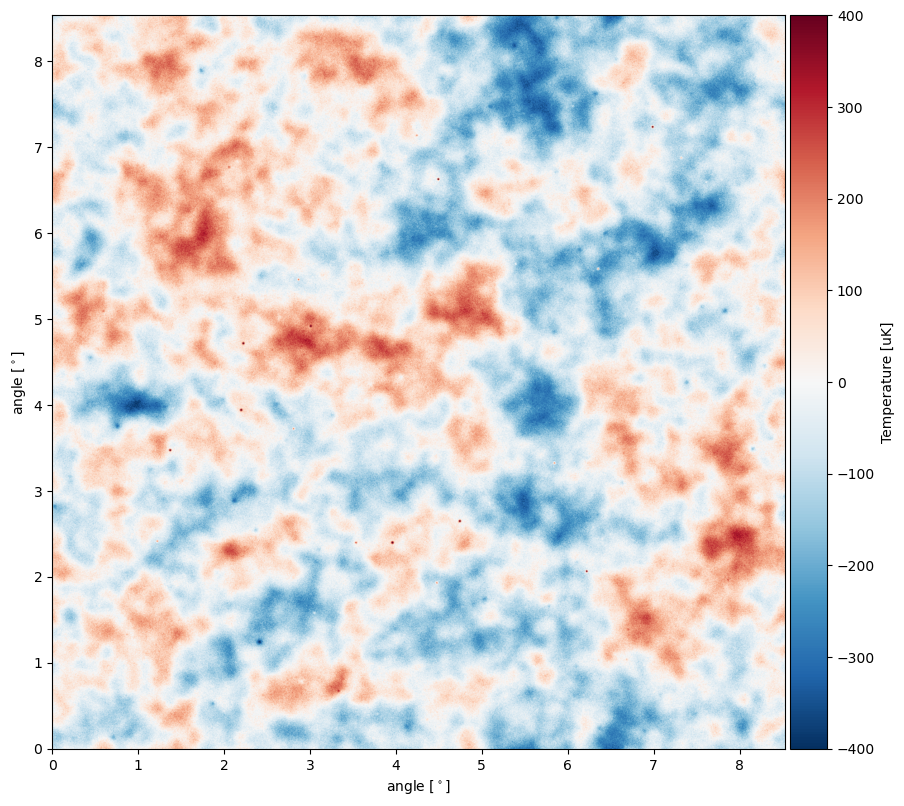

In [3]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = cmb_modules.Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  cmb_modules.Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = cmb_modules.SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise, for the parameteres given above, there is only white noise
Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
p=cmb_modules.Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

In [76]:
white_noise_level

10.0

### Apodize  the map to eliminate edge effects

Before taking a 2d FFT (eg the obvious thing to do for computing a power spectrum) we must apodize the maps to eliminate edges effects.  Edge effects come about because the Fourier transform treats a square array as having periodic boundaries.  Thus if we take the Fourier transform of a 2-dimensional map and the values on the left and right side (and also, top and bottom) of the map don't match, we end up generating spurious signals.   In this example we use a cosine window to smoothly roll off the signal to zero as we approach the edges of the map.  There are many choices of windows that trade sensitivity loss, coupling of adjacent modes, and ringing.

map mean: -7.413695023458107 map rms: 53.48778006823237


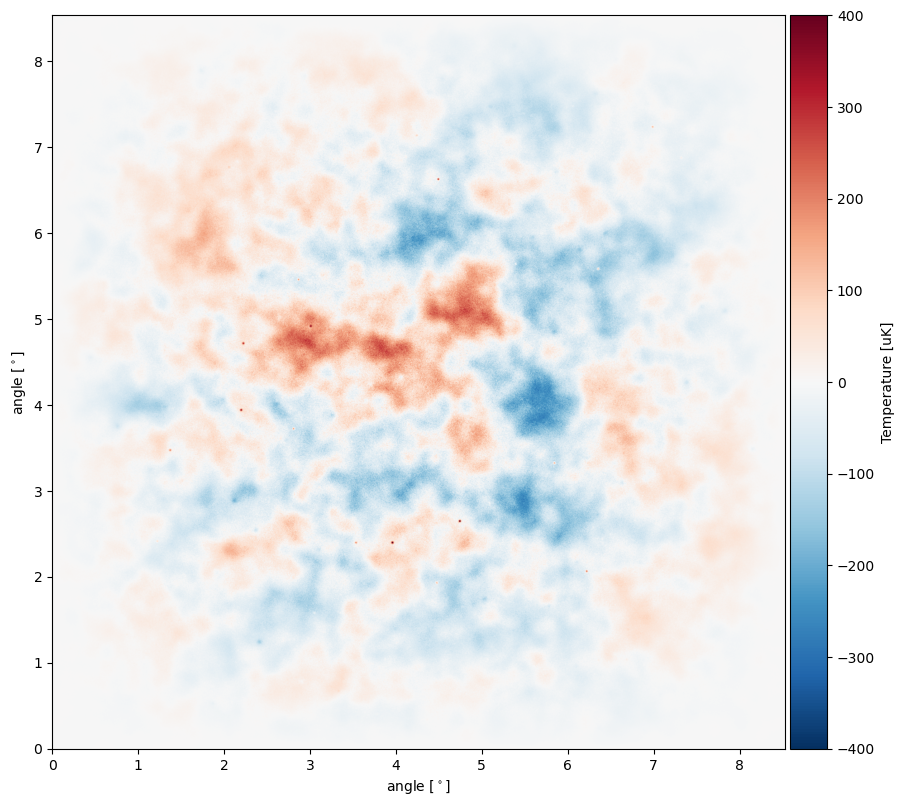

In [4]:
def cosine_window(N):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    N=int(N) 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.)/N *np.pi ## eg runs from -pi/2 to pi/2
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)
  ###############################
    
window = (cosine_window(N))
    
appodized_map = window * total_map_plus_noise

p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,X_width,Y_width)

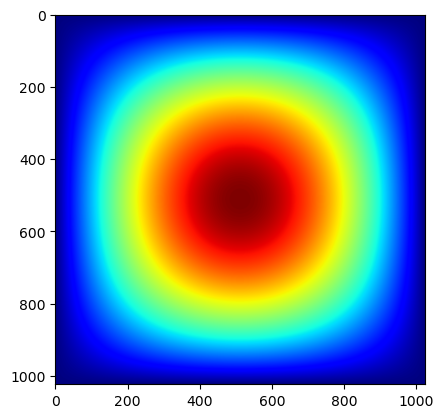

In [78]:
plt.imshow(window, cmap=cm.jet)

This shows our simulated map with a cosine window applied to eliminate edge effects.  It is obvious from this map that we are suppressing the signal here.
<font color='red'>EXERCISE: </font>  There are an huge number of well studied windows with various combinations of properties.   Some minimize mode coupling, others minimize signal loss, while others maximize some combination of the two.  Find the wikipedia article on Fourier transform windows, choose one of your favorites and implement it as an option.  Compare the impact of the new window compared to the simple cosine window on the map.

In [6]:
## your code and plots go here

def tukey_window(N, alpha=0.2):
    """
    Crea una ventana Tukey 2D.
    alpha: Porcentaje del borde que será suavizado (0 a 1).
           0 = Ventana Rectangular (sin suavizado).
           1 = Ventana Hann (coseno completo).
    """
    N = int(N)
    # Generamos una ventana 1D usando lógica de numpy
    # Definimos el rango del índice
    n = np.arange(N)
    
    # Lógica de Tukey 1D manual (para entender qué pasa)
    # 1. Parte izquierda (subida coseno)
    w_1d = np.ones(N)
    L = int(alpha * (N - 1) / 2)
    
    if L > 0:
        # Borde izquierdo
        w_1d[:L] = 0.5 * (1 + np.cos(np.pi * (2 * n[:L] / (alpha * (N - 1)) - 1)))
        # Borde derecho (simétrico)
        w_1d[N-L:] = 0.5 * (1 + np.cos(np.pi * (2 * n[N-L:] / (alpha * (N - 1)) - 2 / alpha + 1)))
    
    # Hacemos el producto exterior para tener la 2D (X * Y)
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def hann_window(N):
    """
    Crea una ventana Hann (Hanning) 2D.
    Toca cero en los bordes estrictamente.
    """
    N = int(N)
    # Fórmula clásica de Hann: 0.5 * (1 - cos(2*pi*n / (N-1)))
    n = np.arange(N)
    w_1d = 0.5 * (1 - np.cos(2 * np.pi * n / (N - 1)))
    
    # Convertir a 2D multiplicando vector columna por vector fila
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def gaussian_window(N, sigma_percent=0.4):
    """
    Crea una ventana Gaussiana 2D.
    sigma_percent: Ancho de la campana relativo al tamaño N.
    """
    N = int(N)
    sigma = sigma_percent * N
    
    # Coordenadas centradas en 0
    x = np.arange(N) - N/2
    
    # Gaussiana 1D: exp(-x^2 / (2*sigma^2))
    w_1d = np.exp(-0.5 * (x / sigma)**2)
    
    # Crear mapa 2D
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def blackman_window(N):
    "Crea una ventana Blackman 2D (muy baja fuga espectral)"
    N = int(N)
    # Numpy ya tiene la fórmula exacta optimizada
    w_1d = np.blackman(N)
    
    # Crear el mapa 2D (cuadrado suavizado)
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def bartlett_window(N):
    "Crea una ventana Triangular (Bartlett) 2D"
    N = int(N)
    w_1d = np.bartlett(N)
    
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def kaiser_window(N, beta=14):
    "Crea una ventana Kaiser 2D. beta controla la forma."
    N = int(N)
    w_1d = np.kaiser(N, beta)
    
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

def flattop_window(N):
    "Crea una ventana Flat Top 2D (preserva mejor la amplitud)"
    N = int(N)
    # Coeficientes específicos para lograr el tope plano
    # Fórmula: w = a0 - a1*cos(2pi*n/N) + a2*cos(4pi*n/N) ...
    # Usamos la implementación de señales de scipy si está disponible, 
    # pero aquí está la versión manual pura con numpy para no depender de scipy:
    n = np.arange(N)
    a0 = 0.21557895
    a1 = 0.41663158
    a2 = 0.27726315
    a3 = 0.083578947
    a4 = 0.006947368
    term = 2 * np.pi * n / (N - 1)
    
    w_1d = (a0 - a1 * np.cos(term) + 
            a2 * np.cos(2 * term) - 
            a3 * np.cos(3 * term) + 
            a4 * np.cos(4 * term))
            
    window_map = np.outer(w_1d, w_1d)
    
    return window_map

apodized_map_turkey = tukey_window(N, alpha=0.2) * total_map_plus_noise
apodized_map_hann = hann_window(N) * total_map_plus_noise
apodized_map_gaussian = gaussian_window(N, sigma_percent=0.4) * total_map_plus_noise
apodized_map_blackman = blackman_window(N) * total_map_plus_noise
apodized_map_bartlett = bartlett_window(N) * total_map_plus_noise
apodized_map_kaiser = kaiser_window(N, beta=14) * total_map_plus_noise
apodized_map_flattop = flattop_window(N) * total_map_plus_noise

map mean: -14.663718759152493 map rms: 92.42302352690878


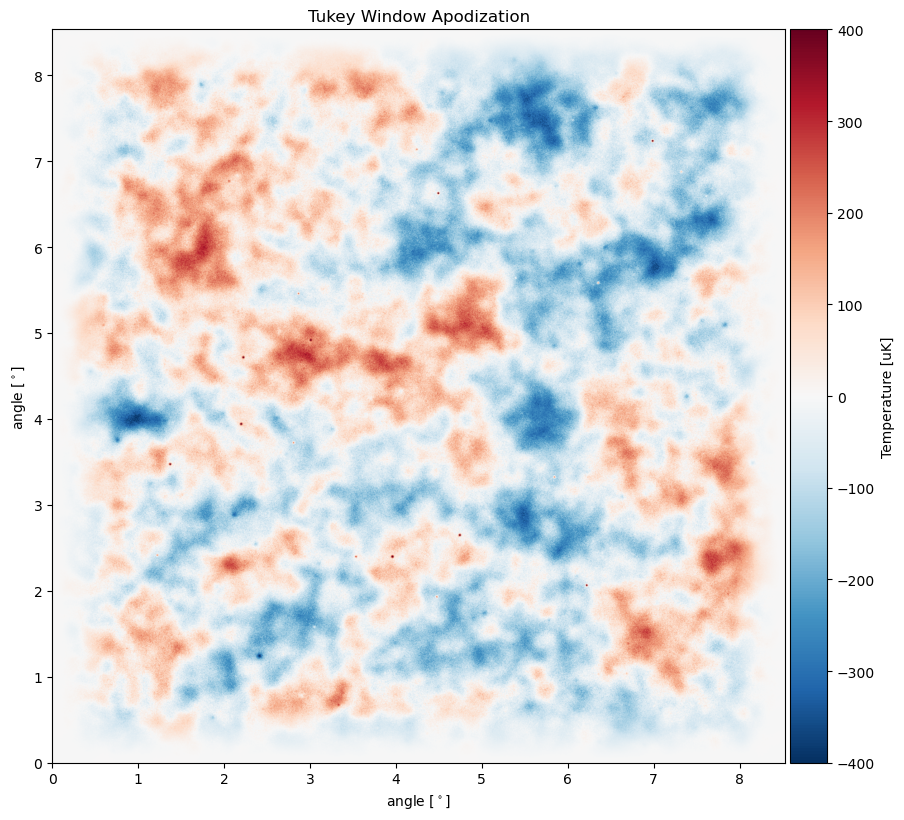

map mean: -4.060160520395823 map rms: 40.630733031683796


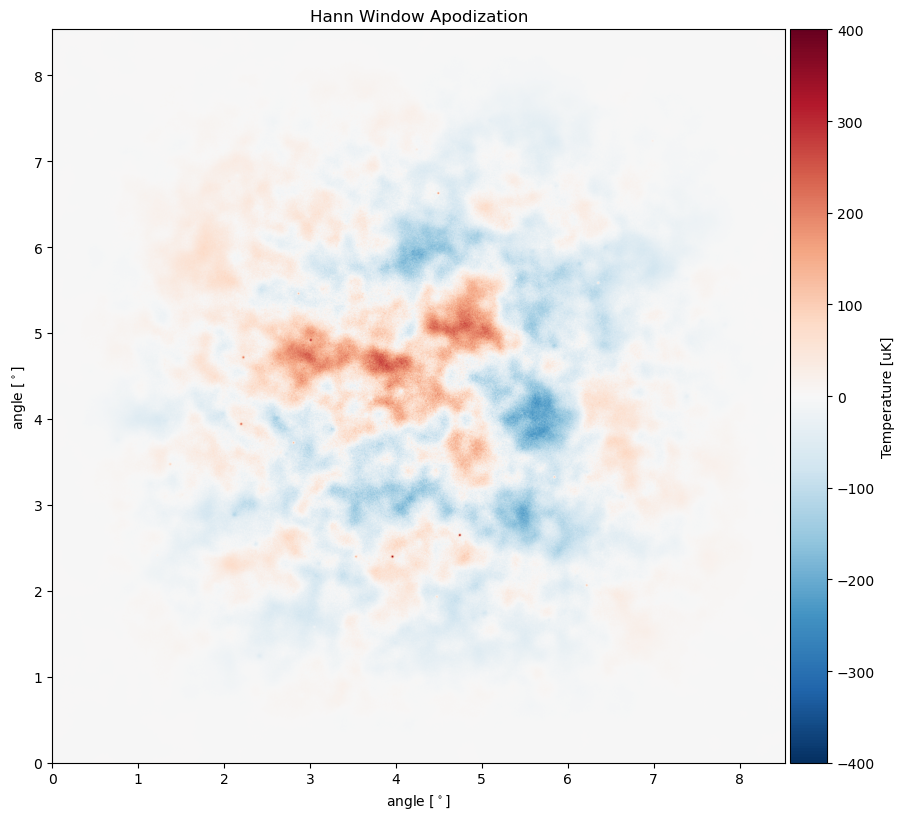

map mean: -12.077633155482797 map rms: 69.04094920608243


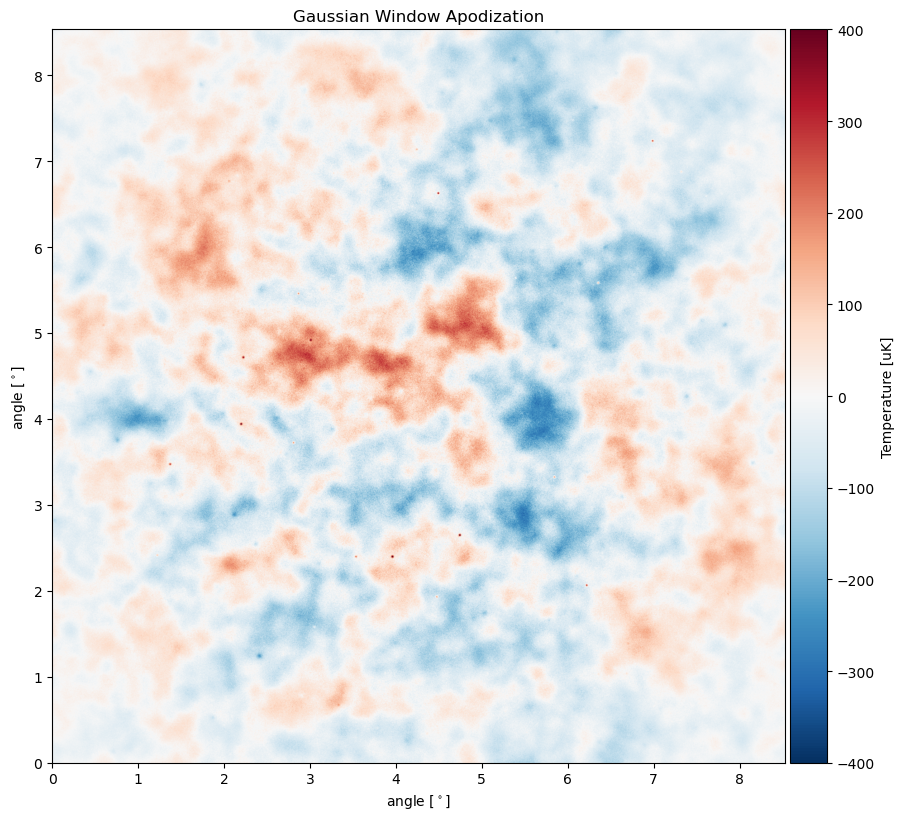

map mean: -2.179697485749641 map rms: 33.19873548614236


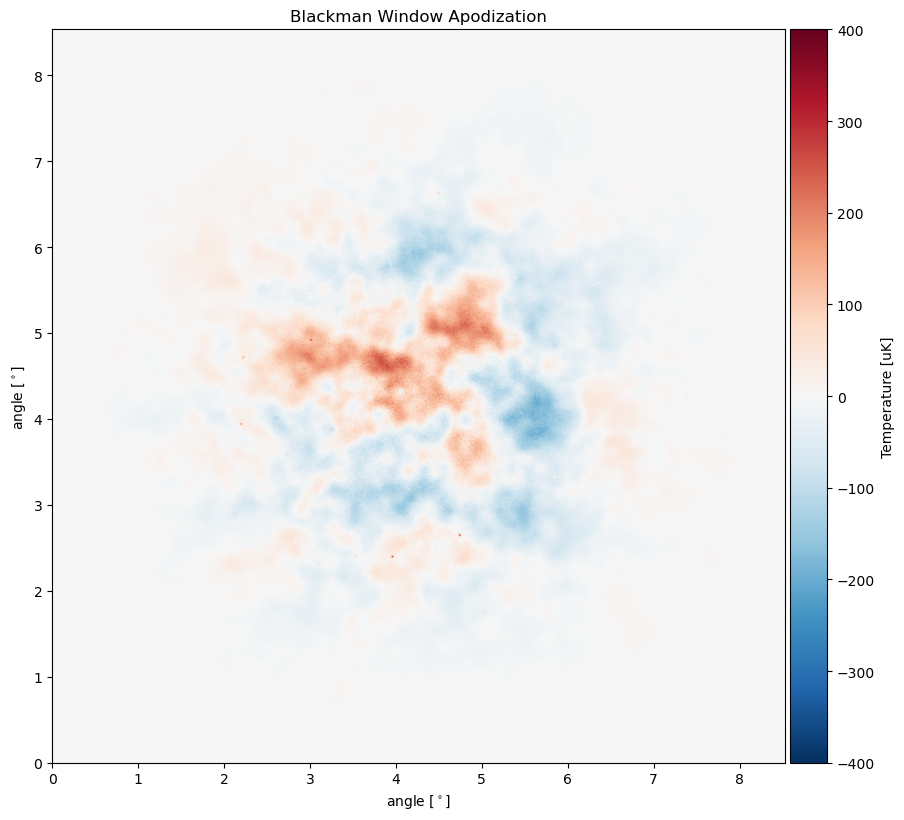

map mean: -4.022497129131918 map rms: 35.779778437617644


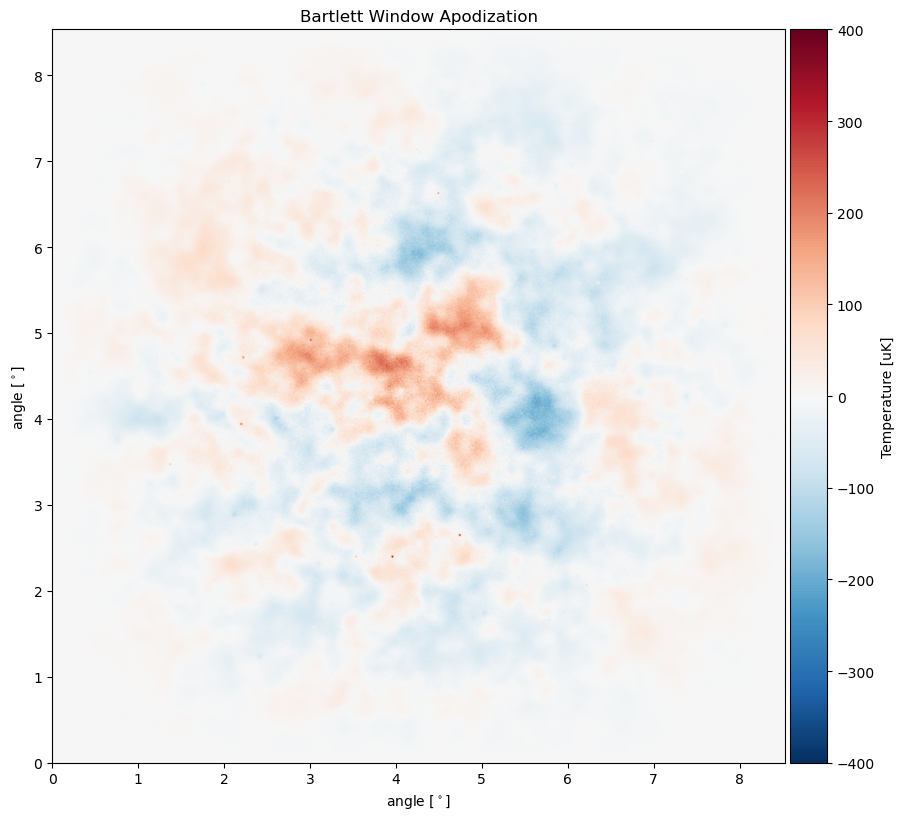

map mean: -0.3622742262342342 map rms: 25.788125584660442


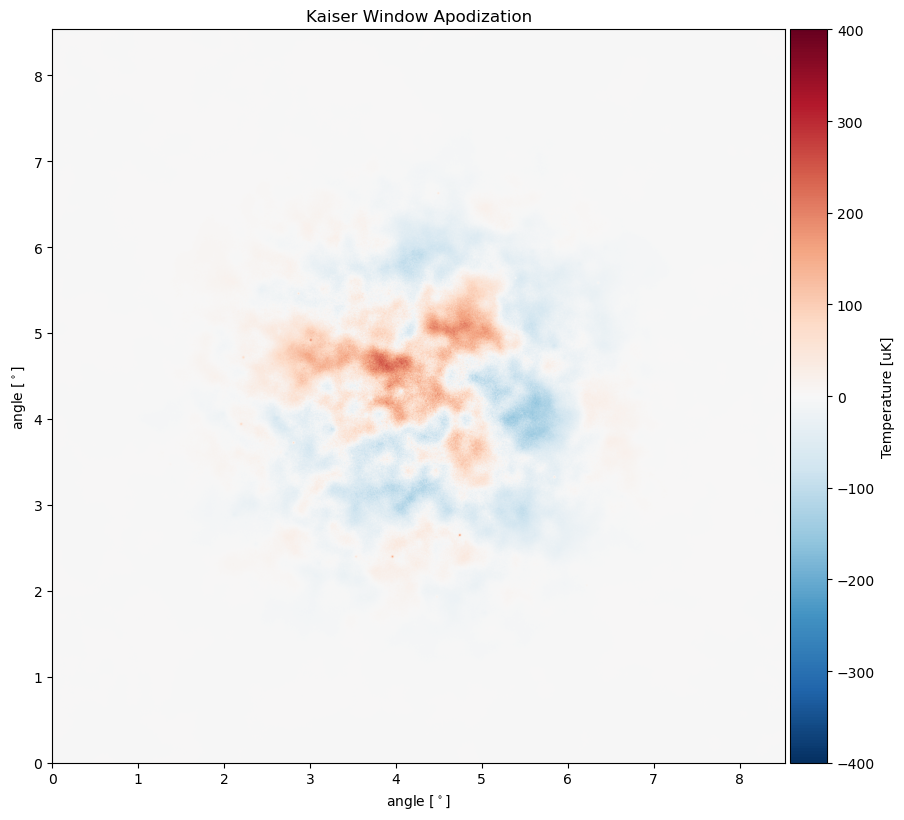

map mean: 1.399760546340838 map rms: 18.19426435376966


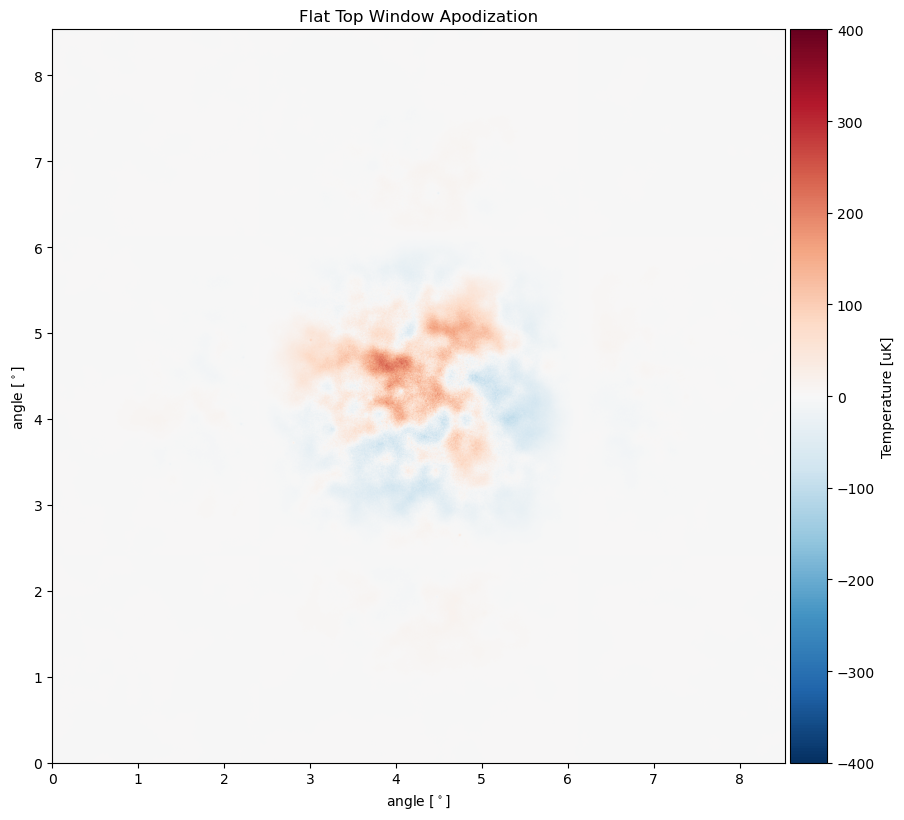

In [7]:
plt.title("Tukey Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_turkey,c_min,c_max,X_width,Y_width)

plt.title("Hann Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_hann,c_min,c_max,X_width,Y_width) 

plt.title("Gaussian Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_gaussian,c_min,c_max,X_width,Y_width)

plt.title("Blackman Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_blackman,c_min,c_max,X_width,Y_width)         

plt.title("Bartlett Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_bartlett,c_min,c_max,X_width,Y_width) 

plt.title("Kaiser Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_kaiser,c_min,c_max,X_width,Y_width)   

plt.title("Flat Top Window Apodization")
cmb_modules.Plot_CMB_Map(apodized_map_flattop,c_min,c_max,X_width,Y_width)  


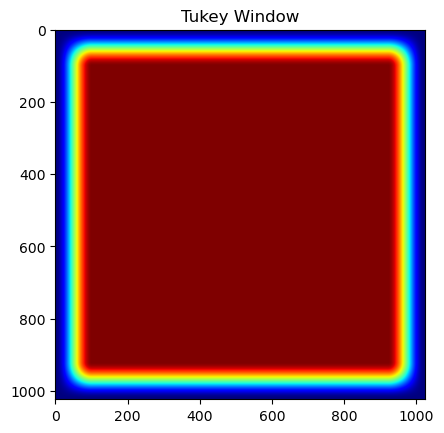

In [81]:
plt.title("Tukey Window")
plt.imshow(tukey_window(N, alpha=0.2), cmap=cm.jet)

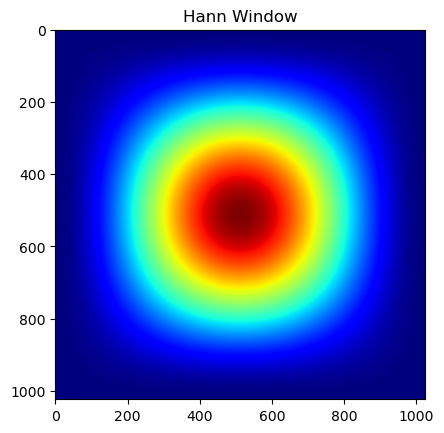

In [82]:
plt.title("Hann Window")
plt.imshow(hann_window(N), cmap=cm.jet)


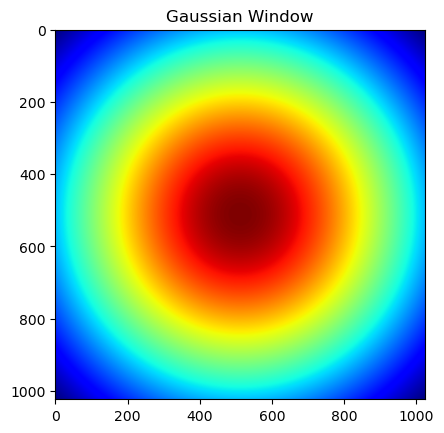

In [83]:
plt.title("Gaussian Window")
plt.imshow(gaussian_window(N, sigma_percent=0.4), cmap=cm.jet)

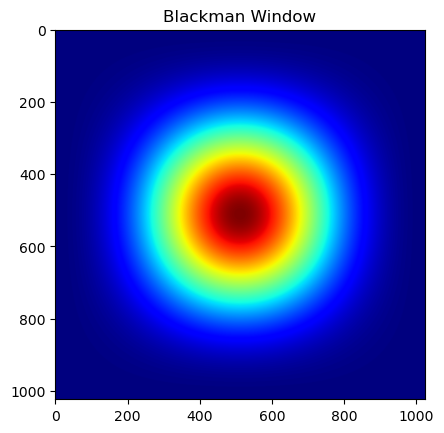

In [84]:
plt.title("Blackman Window")
plt.imshow(blackman_window(N), cmap=cm.jet)


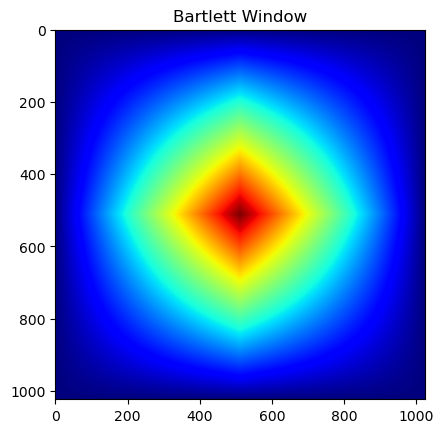

In [85]:
plt.title("Bartlett Window")
plt.imshow(bartlett_window(N), cmap=cm.jet)


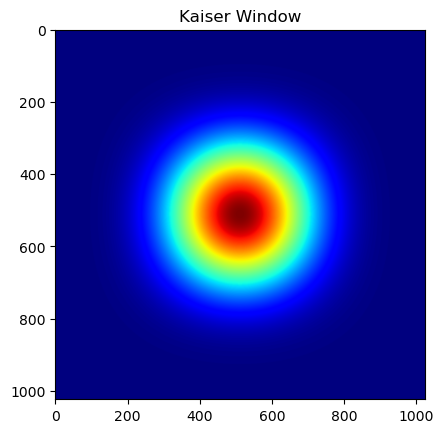

In [86]:
plt.title("Kaiser Window")
plt.imshow(kaiser_window(N, beta=14), cmap=cm.jet)

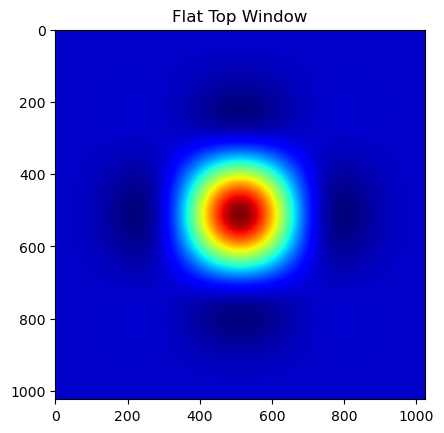

In [87]:
plt.title("Flat Top Window")
plt.imshow(flattop_window(N), cmap=cm.jet)  

Your comments go here.

### Naive Powerspectrum

Here we compute a naive power spectrum and compare it to the input power spectrum for our simulations.  The power spectrum is computed by: (1) applying a 2d FFT, (2) taking the absolute value squared of this map in Fourier space ($k_x$ and $k_y$), and (3) averaging the signal in annular bins of $k = \sqrt{k_x^2 + k_y^2}$.  These bins are converted to bins in $\ell$ with the scaling: $\ell = k* 2 \pi$ per the flat sky approximation.   NOTE: step 3 (averaging in radial bins) is how we convert our 2d Fourier map into a 1d power spectrum.

Our spectrum code takes two maps as inputs to allow for cross spectra when we get to polarizaiton in Part Seven.

<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/3201320588.py:47: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/3201320588.py:48: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


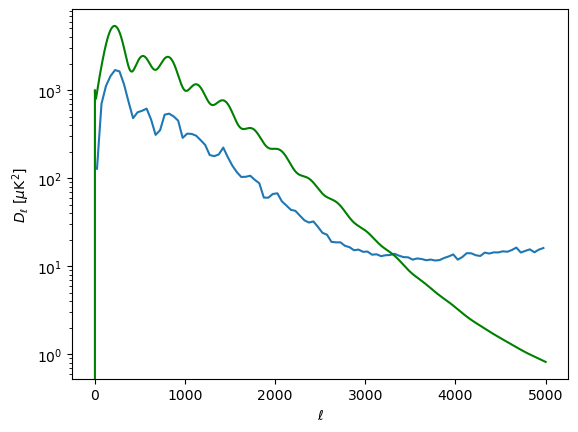

In [16]:
#### parameters for setting up the spectrum
delta_ell = 50.
ell_max = 5000.

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
#print binned_ell.,
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT, color = 'green')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

This plot shows the input CMB power spectrum (green) and the naive power spectrum we estimated from our CMB map (blue).  The naive spectrum does not match the input due to a combination of: instrumental noise, SZ and point source signals; and suppression from the beam and the apodization.   

<font color='red'>EXERCISE: </font>  Comment on how the measured power sepctrum (blue) compares to the input spectrum (green).  Why are they different?  What features are common to both?  How does your alternative window funciton affect the measured spectrum compared to the default?

They are different for things mentioned above, instrumental noise, SZ and point source signals, the beam of the istrument and also the window function you aplied. The things in common is that both spectrum decays a higher $l$, however, for $l$ ~3500 the reconstructed spectrum stop decreasing and stays "constant". I think this is because the window function that we used. So let's try different windows functions.

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/2064920739.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2064920739.py:9: SyntaxWarning: invalid escap

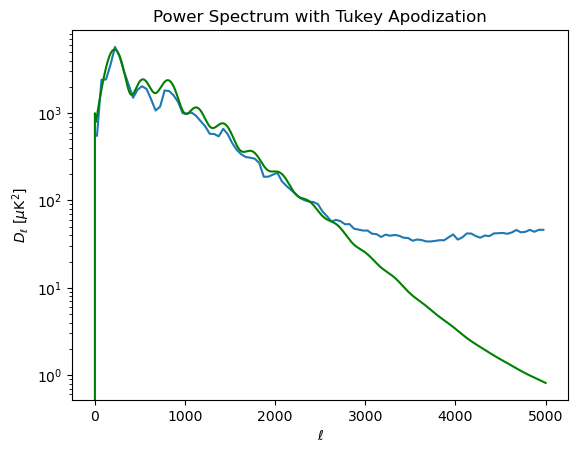

/tmp/ipykernel_16417/2064920739.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2064920739.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')
/tmp/ipykernel_16417/2064920739.py:17: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2064920739.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')
/tmp/ipykernel_16417/2064920739.py:26: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2064920739.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')
/tmp/ipykernel_16417/2064920739.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2064920739.py:36: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


KeyboardInterrupt: 

In [14]:
## your code and plots go here

binned_ell, binned_spectrum = calculate_2d_spectrum(apodized_map_turkey,apodized_map_turkey,delta_ell,ell_max,pix_size,N)
#print binned_ell.,
plt.title("Power Spectrum with Tukey Apodization")
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT, color = 'green')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

binned_ell, binned_spectrum = calculate_2d_spectrum(apodized_map_hann,apodized_map_hann,delta_ell,ell_max,pix_size,N)
#print binned_ell.,
plt.title("Power Spectrum with Hann Apodization")
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT, color = 'green')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

binned_ell, binned_spectrum = calculate_2d_spectrum(apodized_map_gaussian,apodized_map_gaussian,delta_ell,ell_max,pix_size,N)
#print binned_ell.,
plt.title("Power Spectrum with Gaussian Apodization")
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT, color = 'green')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

binned_ell, binned_spectrum = calculate_2d_spectrum(apodized_map_flattop,apodized_map_flattop,delta_ell,ell_max,pix_size,N)
#print binned_ell.,
plt.title("Power Spectrum with Flattop Apodization")
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)
plt.semilogy(ell,DlTT, color = 'green')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()



Your comments go here.

### Correcting the biases in the naive power spectrum

To correct the naive spectrum and obtain an unbiased estimate of the underlying power spectrum in our simulated map we must correct additive bias and multiplicative bias.   We can relate our measured spectrum $\hat D_\ell$ to the true underlying spectrum $D_\ell$ as follows:

$$\hat D_\ell = T*D_\ell + N. $$

Here $N$ represents an additive noise term and $T$ represents a transfer function of the instrument (beam) and filtering (in this case the apodization, but other processing can enter, for example a 1-d high pass filter to eliminate striping).   All of these terms are functions of $\ell$.

The true power spectrum can be recovered by using monte carlo techniques.  To apply this technique we use simulations to calibrate $T$ and $N$ and then use algebra to correct the naive measurement.  This is compactly expressed in the following equation:

$$ D_\ell =  (\hat{D_\ell} - N)/T. $$

In the next two sections we use simulations to calibrate $T$ and $N$ to recover an unbiased estimate of the underlying power spectrum.  Subsequently we will used monte carlo simulations to estimate the error bars on this measurement.

### Calibrating the transfer function

The transfer function can be calibrated by: (1) generating sky simulations with a known power spectrum, modeling the transfer function of the instrument and the post-processing, and keeping the noise level to zero,; and (2) calculating the naive power spectrum from each simulation, (3) running many simulations to reduce numerical noise, and (4) dividing the true spectrum by the the average signal only spectrum to recover our estimate for the transfer function.   The accuracy depends on the number of realizations used.  Here  we used 64 realizations as a compromise between speed and accuracy.  

Here we use a CMB only spectrum to estimate the transfer function.  We could improve the estimate of the transfer function by using an input power spectrum that is modified to follow the effect of point sources.  This could be added as an exercise.  In this exercise compare the transfer function to find out how much the choice of input spectrum matters.

In [17]:
N_iterations = 64

signal_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)
    CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(CMB_T_convolved*window,CMB_T_convolved*window,delta_ell,ell_max,pix_size,N)
    signal_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra = np.zeros(N_ells)
    rmsSpectra = np.zeros(N_ells)
    
    # calcuate the average spectrum
    i = 0
    while (i < N_spectra):
        avgSpectra = avgSpectra + spectra[i,:]
        i = i + 1
    avgSpectra = avgSpectra/(1. * N_spectra)
    
    #calculate the rms of the spectrum
    i =0
    while (i < N_spectra):
        rmsSpectra = rmsSpectra +  (spectra[i,:] - avgSpectra)**2
        i = i + 1
    rmsSpectra = np.sqrt(rmsSpectra/(1. * N_spectra))
    
    return(avgSpectra,rmsSpectra)


sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,int(ell_max/delta_ell))
    
sub_sampled_CLs = DlTT[binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Multiplicative_Bias_est =  sub_sampled_CLs / sig_only_mean_spectrum
   

/home/matias/Documentos/PhD/CMBAnalysis_SummerSchool/cmb_modules.py:15: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


 signal only sims, iterations complete: 64 of 64

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/1008039675.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/1008039675.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


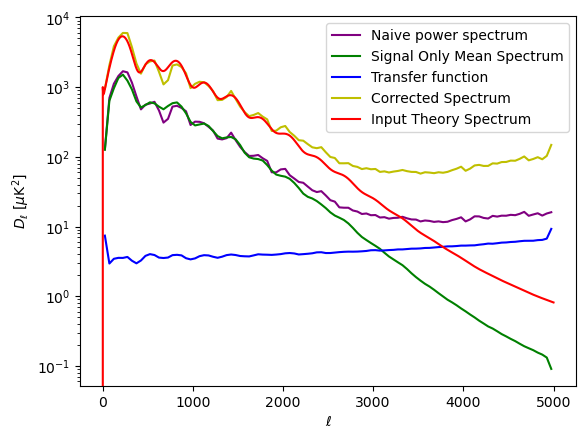

In [19]:
## make some plots
plt.clf()
plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='purple', label = 'Naive power spectrum')
plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g', label = 'Signal Only Mean Spectrum')
plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b', label = 'Transfer function')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='y', label = 'Corrected Spectrum')
plt.semilogy(ell,DlTT,color='r', label = 'Input Theory Spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

This plot shows the estimate of the CMB power spectrum after correcting for the multiplicative bias (transfer function) in yellow.   In addition we show (red) the input CMB power spectrum, (green) the average of the signal only simulations, (purple) the transfer function, and (blue, upper) the naive power spectrum of our map.  Consider how all these curves relate to creating the yellow estimate.
<font color='red'>EXERCISE: </font>  Why does the green curve look so much like the red curved but surpressed?  What is the meaning of the lower (and smoother) blue curve?

The respond of the first cuestion is because this is average between different realizations of the CMB for the binned spectrum (not the theoretical one). The lower curve represents the transfer function $T$, that is just Bias, constructed for different realizations. The upper curve is just the binned spectrum


Your comments go here.

### Calibrating the noise bias

The noise bias can be computed by running noise only simulations through the naive power spectrum estimator and computing the average power spectrum.

NOTE: An alternative approach exists for dealing with the noise.  If you can subdivide your data into subsets with common signal but independent noise, one can compute "cross-spectra" between these subsets.  (You compute these by doing a 2d FFT on each subset and then multiplying one by the complex conjugate of the other.)   This results in some information loss (since you are throwing out the auto-correlation of each subset, but it completely eliminates potential measurement bias from an incorrect noise model.  

As a two part exercise: (1) use the wrong noise model in analyzing the power spectrum to see what happens, and (2) implement a cross-spectrum estimator to see that this noise bias goes away with cross spectra.  Also note that the error bars grow with the cross spectrum. 

<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:25: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/1933433821.py:25: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/1933433821.py:26: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


 noise only sims, iterations complete: 64 of 64

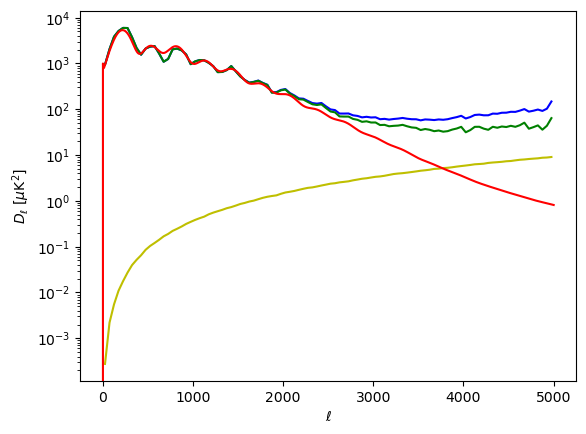

In [20]:
noise_only  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Noise*window,Noise*window,delta_ell,ell_max,pix_size,N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum, rms_not_needed = average_N_spectra(noise_only,N_iterations,int(ell_max/delta_ell))

Additive_Bias_est = noise_only_mean_spectrum


#plt.semilogy(binned_ell,binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
#plt.semilogy(binned_ell,(sig_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(binned_ell,(noise_only_mean_spectrum)* binned_ell * (binned_ell+1.)/2. / np.pi,color='y')
#plt.semilogy(binned_ell,(Multiplicative_Bias_est),color='b')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est*\
             binned_ell * (binned_ell+1.)/2. / np.pi,color='b')
plt.semilogy(binned_ell,(binned_spectrum -noise_only_mean_spectrum)\
             *Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='g')
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

The green curve in this plot shows our unbiased estimate for the spectrum.  This estimate includes corrections for the noise bias and the transfer function.  The yellow curve shows our estimate for the noise only additive bias.  The blue curve shows the spectrum accounting for only the multiplicative bias as was done above.  The red curve shows the underlying power spectrum used in generating our simulated map.

At this point we have an unbiased estimate of the power spectrum (the green curve). Note that at high-$\ell$  the spectrum is dominated by the SZ and point source components.  Next we need to put error bars on this measurement.  Again we do this with the monty carlo approach.

<font color='red'>EXERCISE: </font>  What is the yellow curve?  How is it generated, how is it used to get the green curve?

The yellow curve is the only additive bias, and it's generated running differents realizations of the noise that we implement on our "ideal" CMB. So, if we take the mean of this different realizations, we get this additive bias. Then we can gent the green curve, just subtracting this bias to our binned spectrum (just see the formula that we discuss above). Then, if we multiply the binned spectrum and subtract the bias, we get a estimator for the $D_l$.

your comments go here

### Quantifying the error bars

The error bars are computed by generating simulations including signal and noise, computing the naive power spectrum, taking the RMS of these results and then subtracting the noise bias and accounting for the transfer function.  In effect we are simulating running the experiment a bunch of times and looking at the RMS of the results--- this approach is broadly applicable to other problems.

<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/2558081813.py:34: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/2558081813.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


Number of sources required:  5000
 signal and noise sims, iterations complete: 1 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 2 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 3 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 4 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 5 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 6 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 7 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 8 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 9 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 10 of 64Number of sources required:  5000
 signal and noise sims, iterations complete: 11 of 64Number of sources required:  5000
 signal and noise 

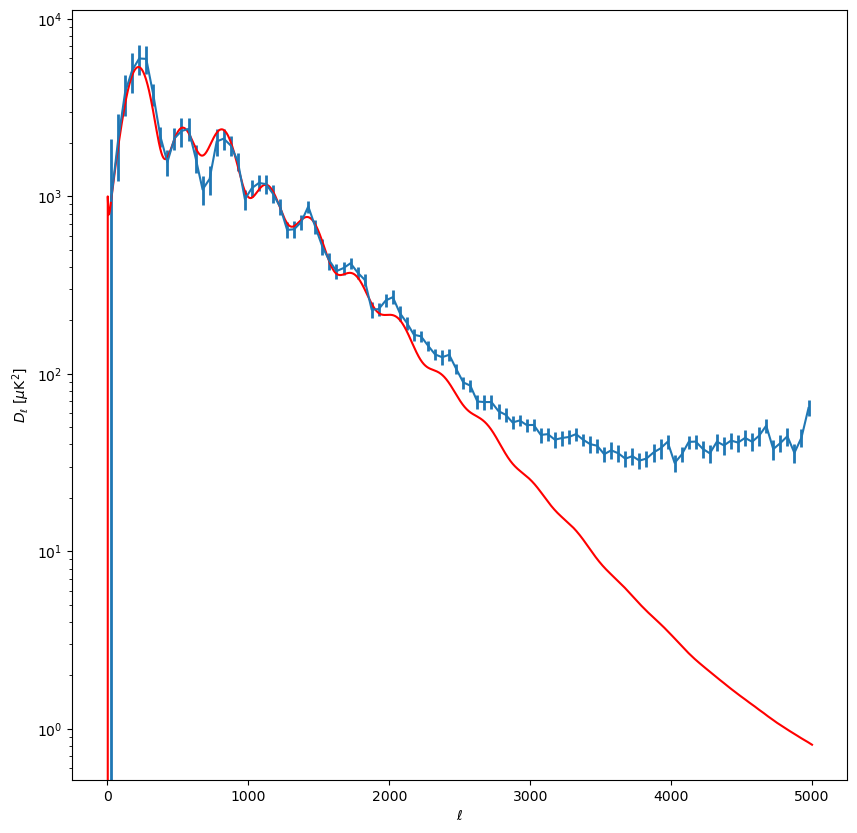

In [21]:
SplusN  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0
while (i <N_iterations):
    CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

    PSMap = cmb_modules.Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap += cmb_modules.Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = cmb_modules.SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                      Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    
    CMB_T  = CMB_T + PSMap + SZMap

    CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum((CMB_T_convolved+Noise)*window\
                                                                ,(CMB_T_convolved+Noise)*window\
                                                                ,delta_ell,ell_max,pix_size,N)
    SplusN[i,:] = binned_spectrum_cur
    sys.stdout.write("\r signal and noise sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    #p=Plot_CMB_Map(CMB_T_convolved+Noise,c_min,c_max,X_width,Y_width)
    i = i + 1
    
mean_not_needed,rms_sig_plus_noise = average_N_spectra(SplusN,N_iterations,int(ell_max/delta_ell))


plt.clf()
plt.gcf().set_size_inches(10, 10)
plt.errorbar(binned_ell, (binned_spectrum -noise_only_mean_spectrum)*Multiplicative_Bias_est* \
             binned_ell * (binned_ell+1.)/2. / np.pi, \
             yerr=rms_sig_plus_noise*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,\
             elinewidth=2)
plt.semilogy(ell,DlTT,color='r')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()




And there you have it.  That is how you compute a CMB power spectrum and error bars.   If you want to fit cosmology to these data you can re-run CAMB varying cosmological parameters and compute the likelihood difference between these models and the data.  This is left as an exercise.
<font color='red'>EXERCISE: </font>  Why dosn't the red curve (input CMB spectrum) fall wihin the error bars of our simulated data set above $\ell \sim 2500$?

Because this input spectrum doesn´t take account the SZ effect, point sources and also, instrumental error, the beam of the instrument and the widndow function, is only CMB signal. 

your comments and discussion go here

<font color='red'>EXERCISE: </font>  One can worry that the transfer funciton calcuation depends on the input spectrum used in its calculation.  Modify the spectrum used in calculating the transfer funciton to better match the spectrum in the simualtion by adding a constant in quadrature to the input spectrum.   Comment on weather this changes the result or not.

your comments go here

In [22]:

signal_only100  = np.zeros([N_iterations,int(ell_max/delta_ell)])
i = 0


binned_ell100, binned_spectrum100 = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

Dltt100 = DlTT + 100
while (i <N_iterations):
    # se añade una constante y veamos q pasa
    CMB_T100 = cmb_modules.make_CMB_T_map(N,pix_size,ell,Dltt100)
    CMB_T_convolved100 = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T100)
    binned_ell_cur100, binned_spectrum_cur100 = calculate_2d_spectrum(CMB_T_convolved100*window,CMB_T_convolved100*window,delta_ell,ell_max,pix_size,N)
    signal_only100[i,:] = binned_spectrum_cur100
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

def average_N_spectra(spectra,N_spectra,N_ells):
    avgSpectra100 = np.zeros(N_ells)
    rmsSpectra100 = np.zeros(N_ells)
    
    # calcuate the average spectrum
    i = 0
    while (i < N_spectra):
        avgSpectra100 = avgSpectra100 + spectra[i,:]
        i = i + 1
    avgSpectra100 = avgSpectra100/(1. * N_spectra)
    
    #calculate the rms of the spectrum
    i =0
    while (i < N_spectra):
        rmsSpectra100 = rmsSpectra100 +  (spectra[i,:] - avgSpectra100)**2
        i = i + 1
    rmsSpectra100 = np.sqrt(rmsSpectra100/(1. * N_spectra))
    
    return(avgSpectra100,rmsSpectra100)


sig_only_mean_spectrum100, rms_not_needed100 = average_N_spectra(signal_only100,N_iterations,int(ell_max/delta_ell))

# ojo que aquí habría que calcular el bineado de nuevo, agregando el término constante (100) -> checkear
sub_sampled_CLs100 = Dltt100[binned_ell] * 2. * np.pi / (binned_ell * (binned_ell+1.))

Multiplicative_Bias_est100 =  sub_sampled_CLs100 / sig_only_mean_spectrum100

/home/matias/Documentos/PhD/CMBAnalysis_SummerSchool/cmb_modules.py:15: RuntimeWarning: divide by zero encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


 signal only sims, iterations complete: 64 of 64

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_16417/4093556852.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
/tmp/ipykernel_16417/4093556852.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$')


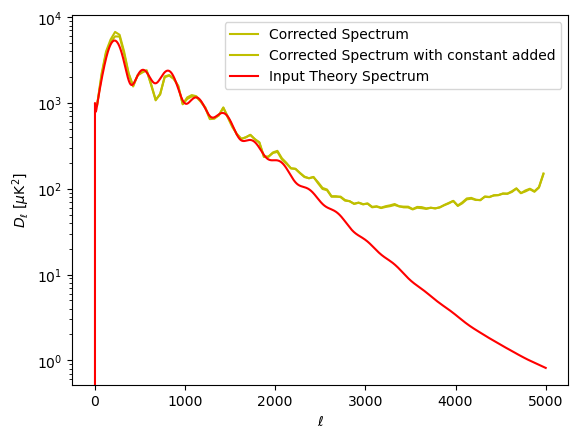

In [23]:
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est* binned_ell * (binned_ell+1.)/2. / np.pi,color='y', label = 'Corrected Spectrum')
plt.semilogy(binned_ell,(binned_spectrum)*Multiplicative_Bias_est100* binned_ell * (binned_ell+1.)/2. / np.pi,color='y', label = 'Corrected Spectrum with constant added')

plt.semilogy(ell,DlTT,color='r', label = 'Input Theory Spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()